In [1]:
import pandas as pd
import csv
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
import string
from nltk import FreqDist
from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gracejeong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# import dataset
df_mbti = pd.read_csv('mbti_1.csv')

In [3]:
df_mbti.shape

(8675, 2)

In [4]:
# preview data
df_mbti.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [5]:
# create variable containing labels (16 unique categories)
categories = df_mbti.type.values
categories = list(set(categories))

In [6]:
# view distritubtion of observations by class type
df_mbti.type.value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

Text(0.5, 1.0, 'Count of Each MBTI Type')

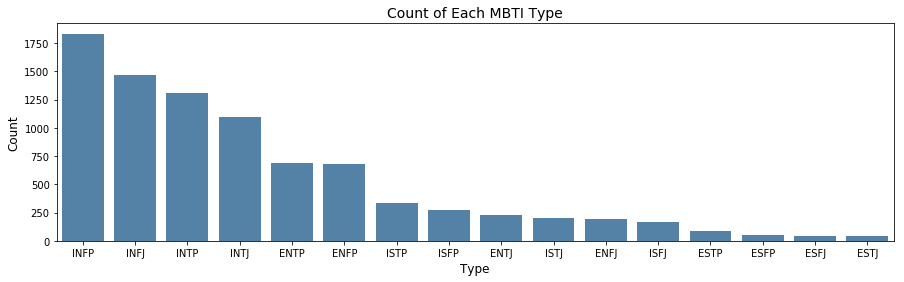

In [7]:
fig = plt.figure(figsize = (15,4))
sns.barplot(df_mbti.type.value_counts().index, df_mbti.type.value_counts(), color = 'steelblue')
plt.xlabel('Type', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.title('Count of Each MBTI Type', fontsize = 14)

In [8]:
def count_caps(text):
    """Returns a count of the number of capitalized letters in text"""
    counter = 0
    for letter in text:
        if letter.isupper() == True:
            counter += 1
    return counter
        

In [9]:
def count_exclamations(text):
    """Returns a count of the number of ! in text"""
    counter = 0
    for letter in text:
        if letter == '!':
            counter += 1
    return counter

In [10]:
def count_digits(text):
    """Returns a count of the number of digits in text"""
    digits = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    counter = 0
    for letter in text:
        if letter in digits:
            counter += 1
    return counter

In [11]:
emojis = [':)', ':]', ':|',':[',':(',
 ';)',
 ':/',
 ':o',
 ':O',
 ':D',
 ':&',
 ":')",
 ":'(",
 ':`(',
 'XD',
 ':X',
 '8X',
 'K0',
 ':p',
 '=O',
 'O:)',
 '>:)',
 '>:(',
 '%p',
 ':@)',
 '=^.^=',
 'ó¿ò',
 'ô¿ô',
 '°¿°',
 '©¿©',
 "'¿'",
 '?:)',
 '?:~)',
 '?8)',
 '8^)',
 'B)',
 '=D',
 ':|',
 '=)',
 '=.=',
 '^_^',
 '^_',
 '^_~',
 '¬_¬',
 '>_<',
 'o_o',
 'O.O',
 'o.O',
 "''",
 'x_x',
 '\\m/><\\m/',
 'ಠ_ಠ',
 ':*',
 '9_9',
 'QQ',
 ':-)',
 ':-]',
 ':-|',
 ':-[',
 ':-(',
 ';-)',
 ':-/',
 ':-o',
 ':-O',
 ':-D',
 ':-&',
 ":'-)",
 ":'-(",
 ':`-(',
 'X-D',
 ':-X',
 '8-X',
 'K-0',
 ':-p',
 '=O',
 'O:-)',
 '>:-)',
 '>:-(',
 '%-p',
 ':@)',
 '=^.^=',
 'ó¿ò',
 'ô¿ô',
 '°¿°',
 '©¿©',
 "'¿'",
 '?:-)',
 '?:~)',
 '?8-)',
 '8^)',
 'B-)',
 '=D',
 ':|',
 '=)',
 '=.=',
 '^_^',
 '^_-',
 '^_~',
 '¬_¬',
 '>_<',
 'o_o',
 'O.O',
 'o.O',
 "'-'",
 'x_x',
 '\\m/><\\m/',
 'ಠ_ಠ',
 ':*',
 '9_9',
 'QQ',
 '@.@']

In [12]:
def count_emojis_shortcode(text):
    shortcodes = re.findall(r'\:[a-z]+\:', str(text))
    return len(shortcodes)

In [13]:
def count_emojis(text):
    counter = 0
    split = text.split(' ')
    for x in emojis:
        counter += sum(x in s for s in split)
    return counter


In [14]:
# create additional features: count of capitalizations, count of exclamations, count of emoj
df_mbti['count_of_caps'] = df_mbti.posts.apply(lambda x: count_caps(x))
df_mbti['count_of_exclamations'] = df_mbti.posts.apply(lambda x: count_exclamations(x))
df_mbti['count_of_digits'] = df_mbti.posts.apply(lambda x: count_digits(x))
df_mbti['count_of_emojis'] = df_mbti.posts.apply(lambda x: count_emojis(x)+count_emojis_shortcode(x))

In [15]:
df_mbti.head()

,type,posts,count_of_caps,count_of_exclamations,count_of_digits,count_of_emojis
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,153,3,109,33
1,ENTP,'I'm finding the lack of me in these posts ver...,327,0,109,22
2,INTP,'Good one _____ https://www.youtube.com/wat...,169,4,94,14
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",253,3,33,2
4,ENTJ,'You're fired.|||That's another silly misconce...,261,1,41,11


/Users/gracejeong/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


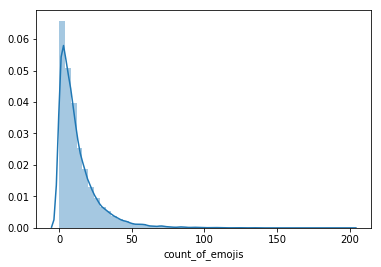

In [16]:
sns.distplot(df_mbti.count_of_emojis)

In [17]:
# clean text: remove hyperlinks, special characters & digits
df_mbti.posts = df_mbti.posts.apply(lambda x: re.sub(r"(http|ftp|https)://([\w+?\.\w+])+([a-zA-Z0-9\~\!\@\#\$\%\^\&\*\(\)_\-\=\+\\\/\?\.\:\;\'\,]*)?", "", x))
df_mbti.posts = df_mbti.posts.apply(lambda x: re.sub(r"\|", "", x))
df_mbti.posts = df_mbti.posts.apply(lambda x: re.sub(r"\d", "", x))
df_mbti.posts = df_mbti.posts.apply(lambda x: re.sub(r"_", "", x))

In [18]:
def lower(text):
    return [word.lower() for word in text]

# tokenize comments & remove stopwords
tokenizer = RegexpTokenizer(r'\w+')
df_mbti['tokenized'] = df_mbti.posts.apply(lambda x: tokenizer.tokenize(x))
df_mbti['tokenized'] = df_mbti.tokenized.apply(lambda x: lower(x))

# nltk.download('stopwords')
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)

def remove_stopwords(tokenized):
    return [word.lower() for word in tokenized if word not in stopwords_list]

In [19]:
df_mbti.head()

,type,posts,count_of_caps,count_of_exclamations,count_of_digits,count_of_emojis,tokenized
0,INFJ,'enfp and intj moments sportscenter not top...,153,3,109,33,"[enfp, and, intj, moments, sportscenter, not, ..."
1,ENTP,'I'm finding the lack of me in these posts ver...,327,0,109,22,"[i, m, finding, the, lack, of, me, in, these, ..."
2,INTP,"'Good one Of course, to which I say I know...",169,4,94,14,"[good, one, of, course, to, which, i, say, i, ..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",253,3,33,2,"[dear, intp, i, enjoyed, our, conversation, th..."
4,ENTJ,'You're fired.That's another silly misconcepti...,261,1,41,11,"[you, re, fired, that, s, another, silly, misc..."


In [20]:
df_mbti['tokens_stopped'] = df_mbti.tokenized.apply(lambda x: remove_stopwords(x))

In [21]:
df_mbti.head()

,type,posts,count_of_caps,count_of_exclamations,count_of_digits,count_of_emojis,tokenized,tokens_stopped
0,INFJ,'enfp and intj moments sportscenter not top...,153,3,109,33,"[enfp, and, intj, moments, sportscenter, not, ...","[enfp, intj, moments, sportscenter, top, ten, ..."
1,ENTP,'I'm finding the lack of me in these posts ver...,327,0,109,22,"[i, m, finding, the, lack, of, me, in, these, ...","[finding, lack, posts, alarming, sex, boring, ..."
2,INTP,"'Good one Of course, to which I say I know...",169,4,94,14,"[good, one, of, course, to, which, i, say, i, ...","[good, one, course, say, know, blessing, curse..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",253,3,33,2,"[dear, intp, i, enjoyed, our, conversation, th...","[dear, intp, enjoyed, conversation, day, esote..."
4,ENTJ,'You're fired.That's another silly misconcepti...,261,1,41,11,"[you, re, fired, that, s, another, silly, misc...","[fired, another, silly, misconception, approac..."


In [22]:
# create features of total words and total unique words
df_mbti['num_total_words'] = df_mbti['tokens_stopped'].apply(lambda x: len(x))
df_mbti['num_unique_words'] = df_mbti['tokens_stopped'].apply(lambda x: len(set(x)))

In [23]:
df_mbti.head()

,type,posts,count_of_caps,count_of_exclamations,count_of_digits,count_of_emojis,tokenized,tokens_stopped,num_total_words,num_unique_words
0,INFJ,'enfp and intj moments sportscenter not top...,153,3,109,33,"[enfp, and, intj, moments, sportscenter, not, ...","[enfp, intj, moments, sportscenter, top, ten, ...",307,257
1,ENTP,'I'm finding the lack of me in these posts ver...,327,0,109,22,"[i, m, finding, the, lack, of, me, in, these, ...","[finding, lack, posts, alarming, sex, boring, ...",561,403
2,INTP,"'Good one Of course, to which I say I know...",169,4,94,14,"[good, one, of, course, to, which, i, say, i, ...","[good, one, course, say, know, blessing, curse...",432,342
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",253,3,33,2,"[dear, intp, i, enjoyed, our, conversation, th...","[dear, intp, enjoyed, conversation, day, esote...",522,374
4,ENTJ,'You're fired.That's another silly misconcepti...,261,1,41,11,"[you, re, fired, that, s, another, silly, misc...","[fired, another, silly, misconception, approac...",482,368


In [24]:
df_mbti.shape

(8675, 10)

In [25]:
from nltk.stem.wordnet import WordNetLemmatizer

In [26]:
def lemmatize(token_stopwords_list):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in token_stopwords_list]


In [27]:
df_mbti['lemmatized'] = df_mbti.tokens_stopped.apply(lambda x: lemmatize(x))

In [28]:
df_mbti['joined_lemmatized']= df_mbti['lemmatized'].apply(lambda x: " ".join(x))

In [29]:
df_mbti.head()

,type,posts,count_of_caps,count_of_exclamations,count_of_digits,count_of_emojis,tokenized,tokens_stopped,num_total_words,num_unique_words,lemmatized,joined_lemmatized
0,INFJ,'enfp and intj moments sportscenter not top...,153,3,109,33,"[enfp, and, intj, moments, sportscenter, not, ...","[enfp, intj, moments, sportscenter, top, ten, ...",307,257,"[enfp, intj, moment, sportscenter, top, ten, p...",enfp intj moment sportscenter top ten play pra...
1,ENTP,'I'm finding the lack of me in these posts ver...,327,0,109,22,"[i, m, finding, the, lack, of, me, in, these, ...","[finding, lack, posts, alarming, sex, boring, ...",561,403,"[finding, lack, post, alarming, sex, boring, p...",finding lack post alarming sex boring position...
2,INTP,"'Good one Of course, to which I say I know...",169,4,94,14,"[good, one, of, course, to, which, i, say, i, ...","[good, one, course, say, know, blessing, curse...",432,342,"[good, one, course, say, know, blessing, curse...",good one course say know blessing curse absolu...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",253,3,33,2,"[dear, intp, i, enjoyed, our, conversation, th...","[dear, intp, enjoyed, conversation, day, esote...",522,374,"[dear, intp, enjoyed, conversation, day, esote...",dear intp enjoyed conversation day esoteric ga...
4,ENTJ,'You're fired.That's another silly misconcepti...,261,1,41,11,"[you, re, fired, that, s, another, silly, misc...","[fired, another, silly, misconception, approac...",482,368,"[fired, another, silly, misconception, approac...",fired another silly misconception approaching ...


In [31]:
df_mbti.columns

Index(['type', 'posts', 'count_of_caps', 'count_of_exclamations',
       'count_of_digits', 'count_of_emojis', 'tokenized', 'tokens_stopped',
       'num_total_words', 'num_unique_words', 'lemmatized',
       'joined_lemmatized'],
      dtype='object')

In [32]:
df_mbti_dropped = df_mbti[['type','count_of_caps', 'count_of_exclamations','count_of_digits', 
                           'count_of_emojis', 'num_total_words', 'num_unique_words', 
                           'joined_lemmatized']]

In [33]:
df_mbti_dropped.head()

,type,count_of_caps,count_of_exclamations,count_of_digits,count_of_emojis,num_total_words,num_unique_words,joined_lemmatized
0,INFJ,153,3,109,33,307,257,enfp intj moment sportscenter top ten play pra...
1,ENTP,327,0,109,22,561,403,finding lack post alarming sex boring position...
2,INTP,169,4,94,14,432,342,good one course say know blessing curse absolu...
3,INTJ,253,3,33,2,522,374,dear intp enjoyed conversation day esoteric ga...
4,ENTJ,261,1,41,11,482,368,fired another silly misconception approaching ...


In [34]:
df_mbti_dropped.to_csv('master_df.csv')

In [35]:
all_lemmatized_posts=[]
for x in df_mbti.lemmatized:
    all_lemmatized_posts.extend(x)
    
all_lemmatized_posts

['enfp',
 'intj',
 'moment',
 'sportscenter',
 'top',
 'ten',
 'play',
 'prankswhat',
 'life',
 'changing',
 'experience',
 'life',
 'repeat',
 'today',
 'may',
 'perc',
 'experience',
 'immerse',
 'last',
 'thing',
 'infj',
 'friend',
 'posted',
 'facebook',
 'committing',
 'suicide',
 'next',
 'day',
 'rest',
 'peace',
 'hello',
 'enfj',
 'sorry',
 'hear',
 'distress',
 'natural',
 'relationship',
 'perfection',
 'time',
 'every',
 'moment',
 'existence',
 'try',
 'figure',
 'hard',
 'time',
 'time',
 'growth',
 'welcome',
 'stuff',
 'game',
 'set',
 'match',
 'prozac',
 'wellbrutin',
 'least',
 'thirty',
 'minute',
 'moving',
 'leg',
 'mean',
 'moving',
 'sitting',
 'desk',
 'chair',
 'weed',
 'moderation',
 'maybe',
 'try',
 'edible',
 'healthier',
 'alternative',
 'basically',
 'come',
 'three',
 'item',
 'determined',
 'type',
 'whichever',
 'type',
 'want',
 'would',
 'likely',
 'use',
 'given',
 'type',
 'cognitive',
 'function',
 'whatnot',
 'left',
 'thing',
 'moderation',
 '

In [36]:
from  nltk import FreqDist
freqdist = FreqDist(all_lemmatized_posts)

# get the 200 most common words 
most_common = freqdist.most_common(200)

In [37]:
most_common

[('like', 71077),
 ('think', 50948),
 ('people', 48145),
 ('one', 40171),
 ('know', 38284),
 ('really', 35257),
 ('would', 34996),
 ('thing', 34553),
 ('time', 33622),
 ('get', 33333),
 ('feel', 25712),
 ('type', 24019),
 ('make', 23643),
 ('much', 23067),
 ('say', 22693),
 ('well', 22591),
 ('friend', 22132),
 ('way', 21759),
 ('love', 21739),
 ('want', 21194),
 ('good', 20722),
 ('see', 19532),
 ('something', 19486),
 ('also', 18286),
 ('lot', 18181),
 ('go', 17439),
 ('even', 16902),
 ('always', 16796),
 ('life', 16462),
 ('someone', 16231),
 ('could', 15275),
 ('never', 15231),
 ('though', 14557),
 ('find', 14387),
 ('year', 14360),
 ('thought', 13967),
 ('need', 13577),
 ('actually', 13168),
 ('infp', 13123),
 ('person', 13008),
 ('work', 12891),
 ('right', 12886),
 ('going', 12711),
 ('first', 12618),
 ('sure', 12570),
 ('pretty', 12310),
 ('yes', 12069),
 ('infj', 12048),
 ('mean', 12028),
 ('feeling', 11605),
 ('intj', 11579),
 ('take', 11521),
 ('day', 11516),
 ('come', 11298)

In [38]:
len(freqdist)

112320

# Modeling

In [39]:
# train-test-split data
x = df_mbti.joined_lemmatized
y = df_mbti.type
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    shuffle = True, 
                                                    random_state = 10, 
                                                    stratify = y)


In [40]:
# vectorize x_train and x_test
vectorizer = TfidfVectorizer()
tfidf_x_train = vectorizer.fit_transform(x_train)
tfidf_x_test = vectorizer.transform(x_test)

In [41]:
tfidf_x_train.shape

(6940, 98488)

In [42]:
tfidf_x_test.shape

(1735, 98488)

## Baseline model - Naive Bayes Classifier

In [43]:
# initiate model_summary list
models_summary = []

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [45]:
# create & run multinomialNB classifier on x_train set
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_x_train, y_train)
nb_train_preds = nb_classifier.predict(tfidf_x_train)
nb_train_score = accuracy_score(y_train, nb_train_preds)
print("Baseline MultinomialNB Classifer (train): ",nb_train_score)

Baseline MultinomialNB Classifer (train):  0.2148414985590778


In [46]:
# run multinomialBN on x_test set
nb_test_preds = nb_classifier.predict(tfidf_x_test)
nb_test_score = accuracy_score(y_test, nb_test_preds)
print("Baseline MultinomialNB Classifer (test): ",nb_test_score)

Baseline MultinomialNB Classifer (test):  0.21152737752161382


In [47]:
# # calculate precision scores across all classes & add to dataframe
# df_precision = pd.DataFrame(precision_score(y_train, nb_train_preds, labels = ['INFP', 'ENFJ','ENFP','ENTJ','ENTP','ESFJ','ESFP','ESTJ','ESTP','INFJ','INTJ','INTP','ISFJ','ISFP','ISTJ','ISTP'], average = None), columns = ['MultinomialNB (baseline)'])


In [48]:
# df_precision['Class'] = ['INFP', 'ENFJ','ENFP','ENTJ','ENTP','ESFJ','ESFP','ESTJ','ESTP','INFJ','INTJ','INTP','ISFJ','ISFP','ISTJ','ISTP']

In [49]:
# df_precision = df_precision[['Class', 'MultinomialNB (baseline)']]

In [50]:
# df_precision

In [51]:
# 'Training Precision': precision_score(y_train, nb_train_preds, average = None),
#                   'Testing Precision': precision_score(y_test, nb_test_preds),
#                   'Training Recall': recall_score(y_train, nb_train_preds),
#                   'Testing Recall': recall_score(y_test, nb_test_preds),
#                   'Training F1-Score': f1_score(y_train, nb_train_preds),
#                   'Testing F1-Score': f1_score(y_test, nb_test_preds)

In [52]:
# models_summary.append({'Model Name': 'MultinomialNB (baseline)',
#                   'Training Accuracy': str(round(nb_train_score,4)*100)+'%',
#                   'Testing Accuracy': str(round(nb_test_score,4)*100)+'%'})

In [53]:
from sklearn.metrics import classification_report

In [54]:
categories = ['INFP', 'ENFJ','ENFP','ENTJ','ENTP','ESFJ','ESFP','ESTJ','ESTP','INFJ','INTJ','INTP','ISFJ','ISFP','ISTJ','ISTP']
print(classification_report(y_test, nb_test_preds, target_names=categories))


              precision    recall  f1-score   support

        INFP       0.00      0.00      0.00        38
        ENFJ       0.00      0.00      0.00       135
        ENFP       0.00      0.00      0.00        46
        ENTJ       0.00      0.00      0.00       137
        ENTP       0.00      0.00      0.00         8
        ESFJ       0.00      0.00      0.00        10
        ESFP       0.00      0.00      0.00         8
        ESTJ       0.00      0.00      0.00        18
        ESTP       0.50      0.00      0.01       294
        INFJ       0.21      1.00      0.35       367
        INTJ       0.00      0.00      0.00       218
        INTP       0.00      0.00      0.00       261
        ISFJ       0.00      0.00      0.00        33
        ISFP       0.00      0.00      0.00        54
        ISTJ       0.00      0.00      0.00        41
        ISTP       0.00      0.00      0.00        67

   micro avg       0.21      0.21      0.21      1735
   macro avg       0.04   

/Users/gracejeong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/gracejeong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/gracejeong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [55]:
# create multiclass ROC-curve for multinomial NB
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression


y = label_binarize(y, classes=['INFP', 'ENFJ','ENFP','ENTJ','ENTP','ESFJ','ESFP','ESTJ','ESTP','INFJ','INTJ','INTP','ISFJ','ISFP','ISTJ','ISTP']) # Binarize the output
n_classes = y.shape[1]

# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=10)

classifier = OneVsRestClassifier(MultinomialNB())
y_score = classifier.fit(tfidf_x_train, y_train).decision_function(tfidf_x_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


AttributeError: 'MultinomialNB' object has no attribute 'decision_function'

## Random Forest (different test_sizes)

In [56]:
def random_forest(test_size):
    x = df_mbti.joined_lemmatized
    y = df_mbti.type
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, shuffle = True, random_state = 10, stratify = y)
    
    vectorizer = TfidfVectorizer()
    tfidf_x_train = vectorizer.fit_transform(x_train)
    tfidf_x_test = vectorizer.transform(x_test)
    
    rf_classifier = RandomForestClassifier(n_estimators = 100)
    rf_classifier.fit(tfidf_x_train, y_train)
    rf_train_preds = rf_classifier.predict(tfidf_x_train)
    rf_test_preds = rf_classifier.predict(tfidf_x_test)
    
    train_accuracy = accuracy_score(y_train, rf_train_preds)
    test_accuracy = accuracy_score(y_test, rf_test_preds)
    
    return train_accuracy, test_accuracy

In [57]:
random_forest(0.5)

(1.0, 0.3812816966343937)

In [79]:
random_forest(0.75)

(1.0, 0.3752881512217612)

In [80]:
random_forest(0.333)

(1.0, 0.398061613014884)

In [81]:
random_forest(0.4)

(1.0, 0.39221902017291066)

## Random Forest w/ GridSearch

In [83]:
from sklearn.model_selection import GridSearchCV

In [58]:
x3 = df_mbti.joined_lemmatized
y3 = df_mbti.type
x_train3, x_test3, y_train3, y_test3 = train_test_split(x3, y3, test_size = 0.333, shuffle = True, random_state = 10, stratify = y)


In [59]:
vectorizer = TfidfVectorizer()
tfidf_x_train3 = vectorizer.fit_transform(x_train3)
tfidf_x_test3 = vectorizer.transform(x_test3)

In [109]:
rf_clf = RandomForestClassifier()

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 1, 2, 5, 10],
    "min_samples_split": [2, 5, 10, 20],
    "n_estimators": [80,100]
}

gs_tree = GridSearchCV(rf_clf, param_grid, cv=3)
gs_tree.fit(tfidf_x_train3, y_train3)

gs_tree.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_split': 10,
 'n_estimators': 100}

In [110]:
def random_forest_gs(criterion, max_depth, min_samples_split, n_estimators):
    x1 = df_mbti.joined_lemmatized
    y1 = df_mbti.type
    x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.333, shuffle = True, random_state = 10, stratify = y)

    vectorizer = TfidfVectorizer()
    tfidf_x_train1 = vectorizer.fit_transform(x1_train)
    tfidf_x_test1 = vectorizer.transform(x1_test)

    rf_classifier = RandomForestClassifier(criterion = criterion, n_estimators = n_estimators, max_depth = max_depth, min_samples_split = min_samples_split)
    rf_classifier.fit(tfidf_x_train1, y1_train)
    rf_train_preds1 = rf_classifier.predict(tfidf_x_train1)
    rf_test_preds1 = rf_classifier.predict(tfidf_x_test1)

    train_accuracy1 = accuracy_score(y1_train, rf_train_preds1)
    test_accuracy1 = accuracy_score(y1_test, rf_test_preds1)
    
    return train_accuracy1, test_accuracy1

In [111]:
random_forest_gs('gini', None, 10, 100)

(0.9996543380573799, 0.4025614399446175)

In [78]:
x1 = df_mbti.joined_lemmatized
y1 = df_mbti.type
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.2, shuffle = True, random_state = 10, stratify = y)

vectorizer = TfidfVectorizer()
tfidf_x_train1 = vectorizer.fit_transform(x1_train)
tfidf_x_test1 = vectorizer.transform(x1_test)

rf_classifier = RandomForestClassifier(criterion = 'gini', n_estimators = 80, max_depth = 10, min_samples_split = 2)
rf_classifier.fit(tfidf_x_train1, y1_train)
rf_train_preds1 = rf_classifier.predict(tfidf_x_train1)
rf_test_preds1 = rf_classifier.predict(tfidf_x_test1)

train_accuracy1 = accuracy_score(y1_train, rf_train_preds1)
test_accuracy1 = accuracy_score(y1_test, rf_test_preds1)

In [89]:
train_accuracy

0.4225717248530937

In [90]:
test_accuracy

0.2665282104534441

In [92]:
train_accuracy1

0.4148414985590778

In [93]:
test_accuracy1

0.2680115273775216

## Decision tree on non-text features

In [97]:
df_mbti.head()

,type,posts,count_of_caps,count_of_exclamations,count_of_digits,count_of_emojis,tokenized,token_stopwords,num_total_words,num_unique_words,lemmatized,joined_lemmatized
0,INFJ,'enfp and intj moments sportscenter not top...,153,3,109,33,"[enfp, and, intj, moments, sportscenter, not, ...","[enfp, intj, moments, sportscenter, top, ten, ...",307,257,"[enfp, intj, moment, sportscenter, top, ten, p...",enfp intj moment sportscenter top ten play pra...
1,ENTP,'I'm finding the lack of me in these posts ver...,327,0,109,22,"[i, m, finding, the, lack, of, me, in, these, ...","[finding, lack, posts, alarming, sex, boring, ...",561,403,"[finding, lack, post, alarming, sex, boring, p...",finding lack post alarming sex boring position...
2,INTP,"'Good one Of course, to which I say I know...",169,4,94,14,"[good, one, of, course, to, which, i, say, i, ...","[good, one, course, say, know, blessing, curse...",432,342,"[good, one, course, say, know, blessing, curse...",good one course say know blessing curse absolu...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",253,3,33,2,"[dear, intp, i, enjoyed, our, conversation, th...","[dear, intp, enjoyed, conversation, day, esote...",522,374,"[dear, intp, enjoyed, conversation, day, esote...",dear intp enjoyed conversation day esoteric ga...
4,ENTJ,'You're fired.That's another silly misconcepti...,261,1,41,11,"[you, re, fired, that, s, another, silly, misc...","[fired, another, silly, misconception, approac...",482,368,"[fired, another, silly, misconception, approac...",fired another silly misconception approaching ...


In [61]:
X = df_mbti[["count_of_caps", "count_of_exclamations", "count_of_digits", "count_of_emojis", "num_total_words", "num_unique_words"]]

In [62]:
X.columns

Index(['count_of_caps', 'count_of_exclamations', 'count_of_digits',
       'count_of_emojis', 'num_total_words', 'num_unique_words'],
      dtype='object')

In [63]:
y_tree = df_mbti.type

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y_tree, test_size = 0.333)

In [65]:
from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier 

In [106]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_hat_test = tree.predict(X_test)
accuracy = accuracy_score(y_test, y_hat_test)
accuracy

0.1585323641398408

In [107]:
y_hat_train = tree.predict(X_train)


In [108]:
accuracy_train = accuracy_score(y_train, y_hat_train)
accuracy_train

1.0

## Merge vectorized sparse matrix and other features

In [66]:
xm = df_mbti[["joined_lemmatized", "count_of_caps", "count_of_exclamations", "count_of_digits", "count_of_emojis", "num_total_words", "num_unique_words"]]
ym = df_mbti.type
xm_train, xm_test, ym_train, ym_test = train_test_split(xm, 
                                                    ym, 
                                                    test_size = 0.2, 
                                                    shuffle = True, 
                                                    random_state = 10, 
                                                    stratify = y)

In [67]:
vectorizer = TfidfVectorizer()
tfidf_x_trainm = vectorizer.fit_transform(xm_train["joined_lemmatized"])
tfidf_x_testm = vectorizer.transform(xm_test['joined_lemmatized'])

In [68]:
tfidf_x_trainm.shape

(6940, 98345)

In [69]:
features_train = np.array(xm_train[["count_of_caps", "count_of_exclamations", "count_of_digits", "count_of_emojis", "num_total_words", "num_unique_words"]])
features_train

array([[364,   8,  31,   1, 392, 282],
       [262,   2,  21,   6, 784, 615],
       [392,  12,  31,  32, 578, 377],
       ...,
       [283,   0,  16,  14, 641, 439],
       [315,  17,  69,   8, 561, 430],
       [238,   1,  31,  18, 358, 274]])

In [70]:
features_test = np.array(xm_test[["count_of_caps", "count_of_exclamations", "count_of_digits", "count_of_emojis", "num_total_words", "num_unique_words"]])
features_test

array([[224,   2,  56,   8, 417, 329],
       [370,  20, 301,  22, 363, 301],
       [195,   0,  41,  11, 558, 383],
       ...,
       [267,  22,  12,  24, 475, 308],
       [177,   2,  58,  14, 495, 402],
       [334,   1,  17,  14, 664, 467]])

In [71]:
import scipy
merged_matrix_train = scipy.sparse.hstack([tfidf_x_trainm,features_train]).toarray()

In [72]:
merged_matrix_train.shape

(6940, 98351)

In [73]:
merged_matrix_test = scipy.sparse.hstack([tfidf_x_testm,features_test]).toarray()

In [74]:
merged_matrix_test.shape

(1735, 98351)

## Random Forest w/ GridSearch on merged matrix

In [65]:
rf_clf = RandomForestClassifier()

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 1, 2, 5, 10],
    "min_samples_split": [2, 5, 10],
    "n_estimators": [80,100]
}

gs_rf_merged = GridSearchCV(rf_clf, param_grid, cv=3)
gs_rf_merged.fit(merged_matrix_train, ym_train)

gs_rf_merged.best_params_

NameError: name 'GridSearchCV' is not defined

In [260]:
rf_clf2 = RandomForestClassifier(criterion = 'gini', max_depth = None, n_estimators= 80)
rf_clf2.fit(merged_matrix_train, ym_train)
ym_train_preds = rf_clf2.predict(merged_matrix_train)
ym_test_preds = rf_clf2.predict(merged_matrix_test)
acc_score_train = accuracy_score(ym_train, ym_train_preds)
acc_score_test = accuracy_score(ym_test, ym_test_preds)

print(acc_score_train)
print(acc_score_test)

1.0
0.3786743515850144


In [262]:
#NB on merged matrix
nb_classifier1 = MultinomialNB()
nb_classifier1.fit(merged_matrix_train, ym_train)
nb_train_preds1 = nb_classifier1.predict(merged_matrix_train)
nb_train_score1 = accuracy_score(ym_train, nb_train_preds1)
nb_train_score1

0.21138328530259365

In [263]:
nb_test_preds1 = nb_classifier1.predict(merged_matrix_test)
nb_test_score1 = accuracy_score(ym_test, nb_test_preds1)
nb_test_score1

0.21210374639769453

## SVM

In [75]:
from sklearn import svm

In [76]:
SVM_model_sum = []

def SVM_classifier_matrix(kernel):
    SVM = svm.SVC(C=1.0, kernel = kernel, degree = 3, gamma = 'auto')
    SVM.fit(tfidf_x_trainm, ym_train)
    SVM_preds_test = SVM.predict(tfidf_x_testm)
    SVM_preds_train = SVM.predict(tfidf_x_trainm)
    train_acc = str(round(accuracy_score(SVM_preds_train, ym_train),4)*100)+'%'
    test_acc = str(round(accuracy_score(SVM_preds_test, ym_test),4)*100)+'%'
    SVM_model_sum.append({'Model Name': 'SVM Classifier ({})'.format(kernel),
                  'Training Accuracy': train_acc,
                  'Testing Accuracy': test_acc,
                  'Training F1-Score': str(round(f1_score(ym_train, SVM_preds_train, average = 'micro'),4)*100)+'%',
                  'Testing F1-Score': str(round(f1_score(ym_test, SVM_preds_test, average = 'micro'),4)*100)+'%'})
    return train_acc, test_acc

In [136]:
SVM_classifier_matrix('linear')

('94.16%', '64.78%')

In [137]:
SVM_classifier_matrix('rbf')

('21.11%', '21.15%')

In [138]:
SVM_classifier_matrix('sigmoid')

('21.11%', '21.15%')

In [139]:
SVM_classifier_matrix('poly')

('21.11%', '21.15%')

In [77]:
#SVM linear model with text data only
SVM = svm.SVC(C=1.0, kernel = 'linear', degree = 3, gamma = 'auto')
SVM.fit(tfidf_x_train, y_train)
SVM_preds_test3 = SVM.predict(tfidf_x_test)
SVM_preds_train3 = SVM.predict(tfidf_x_train)
train_acc3 = str(round(accuracy_score(SVM_preds_train3, y_train),4)*100)+'%'
test_acc3 = str(round(accuracy_score(SVM_preds_test3, y_test),4)*100)+'%'
SVM_model_sum.append({'Model Name': 'SVM Classifier (linear, words only)',
              'Training Accuracy': train_acc3,
              'Testing Accuracy': test_acc3,
              'Training F1-Score': str(round(f1_score(y_train, SVM_preds_train3, average = 'micro'),4)*100)+'%',
              'Testing F1-Score': str(round(f1_score(y_test, SVM_preds_test3, average = 'micro'),4)*100)+'%'})

ValueError: Found input variables with inconsistent numbers of samples: [6940, 5786]

In [141]:
SVM_model_sum

[{'Model Name': 'SVM Classifier (linear)',
  'Training Accuracy': '94.16%',
  'Testing Accuracy': '64.78%',
  'Training F1-Score': '94.16%',
  'Testing F1-Score': '64.78%'},
 {'Model Name': 'SVM Classifier (rbf)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%',
  'Training F1-Score': '21.11%',
  'Testing F1-Score': '21.15%'},
 {'Model Name': 'SVM Classifier (sigmoid)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%',
  'Training F1-Score': '21.11%',
  'Testing F1-Score': '21.15%'},
 {'Model Name': 'SVM Classifier (poly)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%',
  'Training F1-Score': '21.11%',
  'Testing F1-Score': '21.15%'},
 {'Model Name': 'SVM Classifier (linear, words only)',
  'Training Accuracy': '94.28%',
  'Testing Accuracy': '65.01%',
  'Training F1-Score': '94.28%',
  'Testing F1-Score': '65.01%'}]

In [142]:
df_SVM_sum = pd.DataFrame(SVM_model_sum)
df_SVM_sum

,Model Name,Testing Accuracy,Testing F1-Score,Training Accuracy,Training F1-Score
0,SVM Classifier (linear),64.78%,64.78%,94.16%,94.16%
1,SVM Classifier (rbf),21.15%,21.15%,21.11%,21.11%
2,SVM Classifier (sigmoid),21.15%,21.15%,21.11%,21.11%
3,SVM Classifier (poly),21.15%,21.15%,21.11%,21.11%
4,"SVM Classifier (linear, words only)",65.01%,65.01%,94.28%,94.28%


In [143]:
df_SVM_sum.to_csv('df_SVM_sum.csv')

In [ ]:
categories = ['INFP', 'ENFJ','ENFP','ENTJ','ENTP','ESFJ','ESFP','ESTJ','ESTP','INFJ','INTJ','INTP','ISFJ','ISFP','ISTJ','ISTP']
for i in SVM_model_sum:
    print(classification_report(y_true, y_pred, target_names=categories)

In [67]:
SVM = svm.SVC(C=1.0, kernel = 'linear', degree = 3, gamma = 'auto')
SVM.fit(tfidf_x_trainm, ym_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [68]:
SVM_preds_test = SVM.predict(tfidf_x_testm)
SVM_preds_train = SVM.predict(tfidf_x_trainm)

In [69]:
accuracy_score(SVM_preds_train, ym_train)

0.94164265129683

In [70]:
accuracy_score(SVM_preds_test, ym_test)

0.6478386167146974

In [119]:
SVM_f1_train_lin = f1_score(ym_train, SVM_preds_train, average = 'micro')
SVM_f1_test_lin = f1_score(ym_test, SVM_preds_test, average = 'micro')

In [123]:
SVM_model_sum[0]['Training F1-Score'] = str(round(SVM_f1_train_lin,4)*100)+'%'
SVM_model_sum[0]['Testing F1-Score'] = str(round(SVM_f1_test_lin,4)*100)+'%'

In [124]:
SVM_model_sum

[{'Model Name': 'SVM Classifier (linear)',
  'Training Accuracy': '94.16%',
  'Testing Accuracy': '64.78%',
  'Training F1-Score': '94.16%',
  'Testing F1-Score': '64.78%'},
 {'Model Name': 'SVM Classifier (poly)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (rbf)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (sigmoid)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (poly)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (rbf)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (sigmoid)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (linear, words only)',
  'Training Accuracy': '94.28%',
  'Testing Accuracy': '65.01%'}]

In [125]:
df_model_sum = pd.DataFrame(SVM_model_sum)

In [126]:
df_model_sum

,Model Name,Testing Accuracy,Testing F1-Score,Training Accuracy,Training F1-Score
0,SVM Classifier (linear),64.78%,64.78%,94.16%,94.16%
1,SVM Classifier (poly),21.15%,NaN,21.11%,NaN
2,SVM Classifier (rbf),21.15%,NaN,21.11%,NaN
3,SVM Classifier (sigmoid),21.15%,NaN,21.11%,NaN
4,SVM Classifier (poly),21.15%,NaN,21.11%,NaN
5,SVM Classifier (rbf),21.15%,NaN,21.11%,NaN
6,SVM Classifier (sigmoid),21.15%,NaN,21.11%,NaN
7,"SVM Classifier (linear, words only)",65.01%,NaN,94.28%,NaN


In [131]:
SVM_model_sum

[{'Model Name': 'SVM Classifier (poly)',
  'Training Accuracy': 0.21109510086455333,
  'Testing Accuracy': 0.21152737752161382}]

In [ ]:
SVM_model_sum[0]['Training F1-Score'] = str(round(SVM_f1_train_lin,4)*100)+'%'
SVM_model_sum[0]['Testing F1-Score'] = str(round(SVM_f1_test_lin,4)*100)+'%'

In [90]:
rbf = SVM_classifier('rbf')

(0.21109510086455333, 0.21152737752161382)

In [91]:
sigmoid = SVM_classifier('sigmoid')

(0.21109510086455333, 0.21152737752161382)

In [93]:
#SVM model (linear) on text data only
SVM = svm.SVC(C=1.0, kernel = 'linear', degree = 3, gamma = 'auto')
SVM.fit(tfidf_x_train, y_train)
SVM_preds_test3 = SVM.predict(tfidf_x_test)
SVM_preds_train3 = SVM.predict(tfidf_x_train)
train_acc3 = accuracy_score(SVM_preds_train3, y_train)
test_acc3 = accuracy_score(SVM_preds_test3, y_test)
SVM_model_sum.append({'Model Name': 'SVM Classifier (kernel = linear; vectorized words only)',
              'Training Accuracy': train_acc3,
              'Testing Accuracy': test_acc3})


NameError: name 'train_acc' is not defined

In [108]:
SVM_model_sum

[{'Model Name': 'SVM Classifier (linear)',
  'Training Accuracy': '94.16%',
  'Testing Accuracy': '64.78%'},
 {'Model Name': 'SVM Classifier (poly)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (rbf)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (sigmoid)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (poly)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (rbf)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (sigmoid)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (kernel = linear; vectorized words only)',
  'Training Accuracy': '94.28%',
  'Testing Accuracy': '65.01%'}]

In [106]:
for i in SVM_model_sum:
    i['Training Accuracy'] = str(round(i['Training Accuracy'],4)*100)+'%'
    i['Testing Accuracy'] = str(round(i['Testing Accuracy'],4)*100)+'%'

TypeError: type str doesn't define __round__ method

In [107]:
SVM_model_sum

[{'Model Name': 'SVM Classifier (linear)',
  'Training Accuracy': '94.16%',
  'Testing Accuracy': '64.78%'},
 {'Model Name': 'SVM Classifier (poly)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (rbf)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (sigmoid)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (poly)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (rbf)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (sigmoid)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (kernel = linear; vectorized words only)',
  'Training Accuracy': '94.28%',
  'Testing Accuracy': '65.01%'}]

In [109]:
SVM_model_sum[-1]['Model Name'] = 'SVM Classifier (linear, words only)'

In [110]:
df_model_sum = pd.DataFrame(SVM_model_sum)

In [111]:
df_model_sum

,Model Name,Testing Accuracy,Training Accuracy
0,SVM Classifier (linear),64.78%,94.16%
1,SVM Classifier (poly),21.15%,21.11%
2,SVM Classifier (rbf),21.15%,21.11%
3,SVM Classifier (sigmoid),21.15%,21.11%
4,SVM Classifier (poly),21.15%,21.11%
5,SVM Classifier (rbf),21.15%,21.11%
6,SVM Classifier (sigmoid),21.15%,21.11%
7,"SVM Classifier (linear, words only)",65.01%,94.28%


In [115]:
df_model_sum.drop(axis = 0, index = [1,2,3], inplace = True)

KeyError: '[1 2 3] not found in axis'

In [117]:
df_model_sum

,Model Name,Testing Accuracy,Training Accuracy
0,SVM Classifier (linear),64.78%,94.16%
4,SVM Classifier (poly),21.15%,21.11%
5,SVM Classifier (rbf),21.15%,21.11%
6,SVM Classifier (sigmoid),21.15%,21.11%
7,"SVM Classifier (linear, words only)",65.01%,94.28%


In [114]:
df_model_sum.to_csv('SVM_summary.csv')

## Create MBTI predictor function

In [220]:
def predict_MBTI(text_string):
    text_string =[word for word in text_string.split() if word not in stopwords_list]
    text_string = ' '.join(text_string)
    tfidf_text = TfidfVectorizer.transform([text_string])
    prediction = SVM.predict(tfidf_text)
    return prediction
    

In [221]:
text_string = "the Border, or large sections of the Border, next week. This would be so easy for Mexico to do, but they just take our money and “talk.” Besides, we lose so much money with them, especially when you add in drug trafficking etc.), that the Border closing would be a good thing!"

In [222]:
predict_MBTI(text_string)

TypeError: transform() missing 1 required positional argument: 'raw_documents'

In [217]:
TfidfVectorizer.transform(text_string)

TypeError: transform() missing 1 required positional argument: 'raw_documents'

In [211]:
split = text_string.split()

In [ ]:
mbti_descriptions = {'ISTP': 'Burning random object', 'INTP':'Reading their book',
                     'INFP': 'Writing their diary', 'ENTJ': 'Looking at the way that is coming',
                     'ISFJ': 'Looking at the way they\'re leaving behind', 'ISTJ': 'Mr. Driver (simultaneously nice and grumpy)',
                     'INFJ': 'Watching everybody and thinking about how crazy humanity is', 'ESTP':'Hesitating the cars coming behind',
                     'ENTP': 'Whispering weird things to ENFP, trying to enter in their subconcious', 'ENFP': 'Got asleep, dreams with some parallel universe',
                     'ENFJ': 'Just met ESFJ and started talking and are super friends now', 'ESFJ': 'Just met ENFJ and started talking and are super friends now',
                     'ISFP': 'Looking to the landscapes, smartphone ready to make some photos', 'INTJ':'Just had a revelation that solves their current project',
                     'ESFP': 'Checking their air in the rearview', 'ESTJ': 'Checking how Mr. Driver drives, sometimes giving him advice'
                    }

In [ ]:
#SVM model (linear) on text data only
SVM = svm.SVC(C=1.0, kernel = 'linear', degree = 3, gamma = 'auto')
SVM.fit(tfidf_x_train, y_train)
SVM_preds_test3 = SVM.predict(tfidf_x_test)
SVM_preds_train3 = SVM.predict(tfidf_x_train)
train_acc3 = accuracy_score(SVM_preds_train3, y_train)
test_acc3 = accuracy_score(SVM_preds_test3, y_test)
SVM_model_sum.append({'Model Name': 'SVM Classifier (kernel = linear; vectorized words only)',
              'Training Accuracy': train_acc3,
              'Testing Accuracy': test_acc3})


In [ ]:
predict_MBTI("")

## ROC Curve

In [ ]:
# from sklearn.linear_model import LogisticRegression
# SVM = svm.SVC(C=1.0, kernel = 'linear', degree = 3, gamma = 'auto')
# SVM.fit(tfidf_x_train, y_train)

# from sklearn.metrics import roc_curve, auc
# y_score_1 = SVM.fit(tfidf_x_train, y_train).decision_function(tfidf_x_test)# y score = the predicted log-odds

# fpr, tpr, thresholds = roc_curve(y_test, y_score_1)



In [194]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt

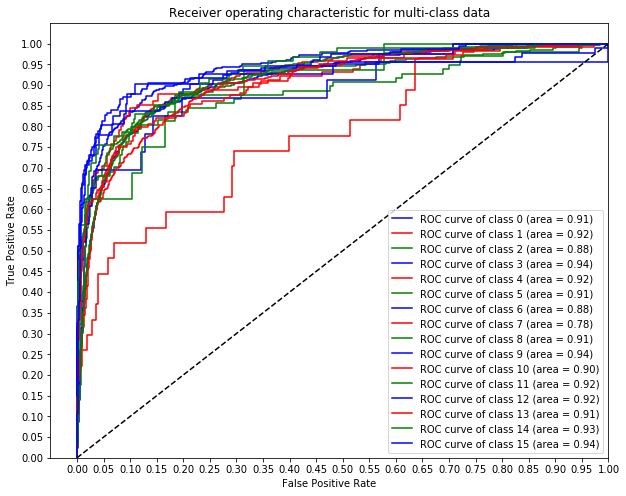

In [200]:
y_bin= label_binarize(y, classes=['INFP', 'ENFJ','ENFP','ENTJ','ENTP','ESFJ','ESFP','ESTJ','ESTP','INFJ','INTJ','INTP','ISFJ','ISFP','ISTJ','ISTP'])

X_train, X_test, y_train, y_test = train_test_split(x, y_bin, test_size=.5, random_state=0)

tfidf_x_train = vectorizer.fit_transform(X_train)
tfidf_x_test = vectorizer.transform(X_test)


classifier = OneVsRestClassifier(SVM)
y_score = classifier.fit(tfidf_x_train, y_train).decision_function(tfidf_x_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
plt.figure(figsize=(10,8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [198]:
print(classification_report(tfidf_x_test, SVM_preds_test3))

ValueError: Found input variables with inconsistent numbers of samples: [4338, 1735]

In [ ]:
#SVM linear model with text data only
SVM = svm.SVC(C=1.0, kernel = 'linear', degree = 3, gamma = 'auto')
SVM.fit(tfidf_x_train, y_train)
SVM_preds_test3 = SVM.predict(tfidf_x_test)
SVM_preds_train3 = SVM.predict(tfidf_x_train)
train_acc3 = str(round(accuracy_score(SVM_preds_train3, y_train),4)*100)+'%'
test_acc3 = str(round(accuracy_score(SVM_preds_test3, y_test),4)*100)+'%'
SVM_model_sum.append({'Model Name': 'SVM Classifier (linear, words only)',
              'Training Accuracy': train_acc3,
              'Testing Accuracy': test_acc3,
              'Training F1-Score': str(round(f1_score(y_train, SVM_preds_train3, average = 'micro'),4)*100)+'%',
              'Testing F1-Score': str(round(f1_score(y_test, SVM_preds_test3, average = 'micro'),4)*100)+'%'})